# Package Imports

## Importing relevant python libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import optuna
import copy
import numpy as np
import torch
from optuna.exceptions import TrialPruned
from imblearn.over_sampling import SMOTE

f:\NTU Projects\sc4001-1\buh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing our utility scripts

In [2]:
from utils.preprocessing import *
from utils.architectures.hybrid import *
from utils.architectures.gru import *
from utils.training.trainer import *
from utils.training.training import *
from utils.evaluation import *
from utils.postprocessing import *

In [3]:
import random

seed = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# Preprocessing Data

In [4]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


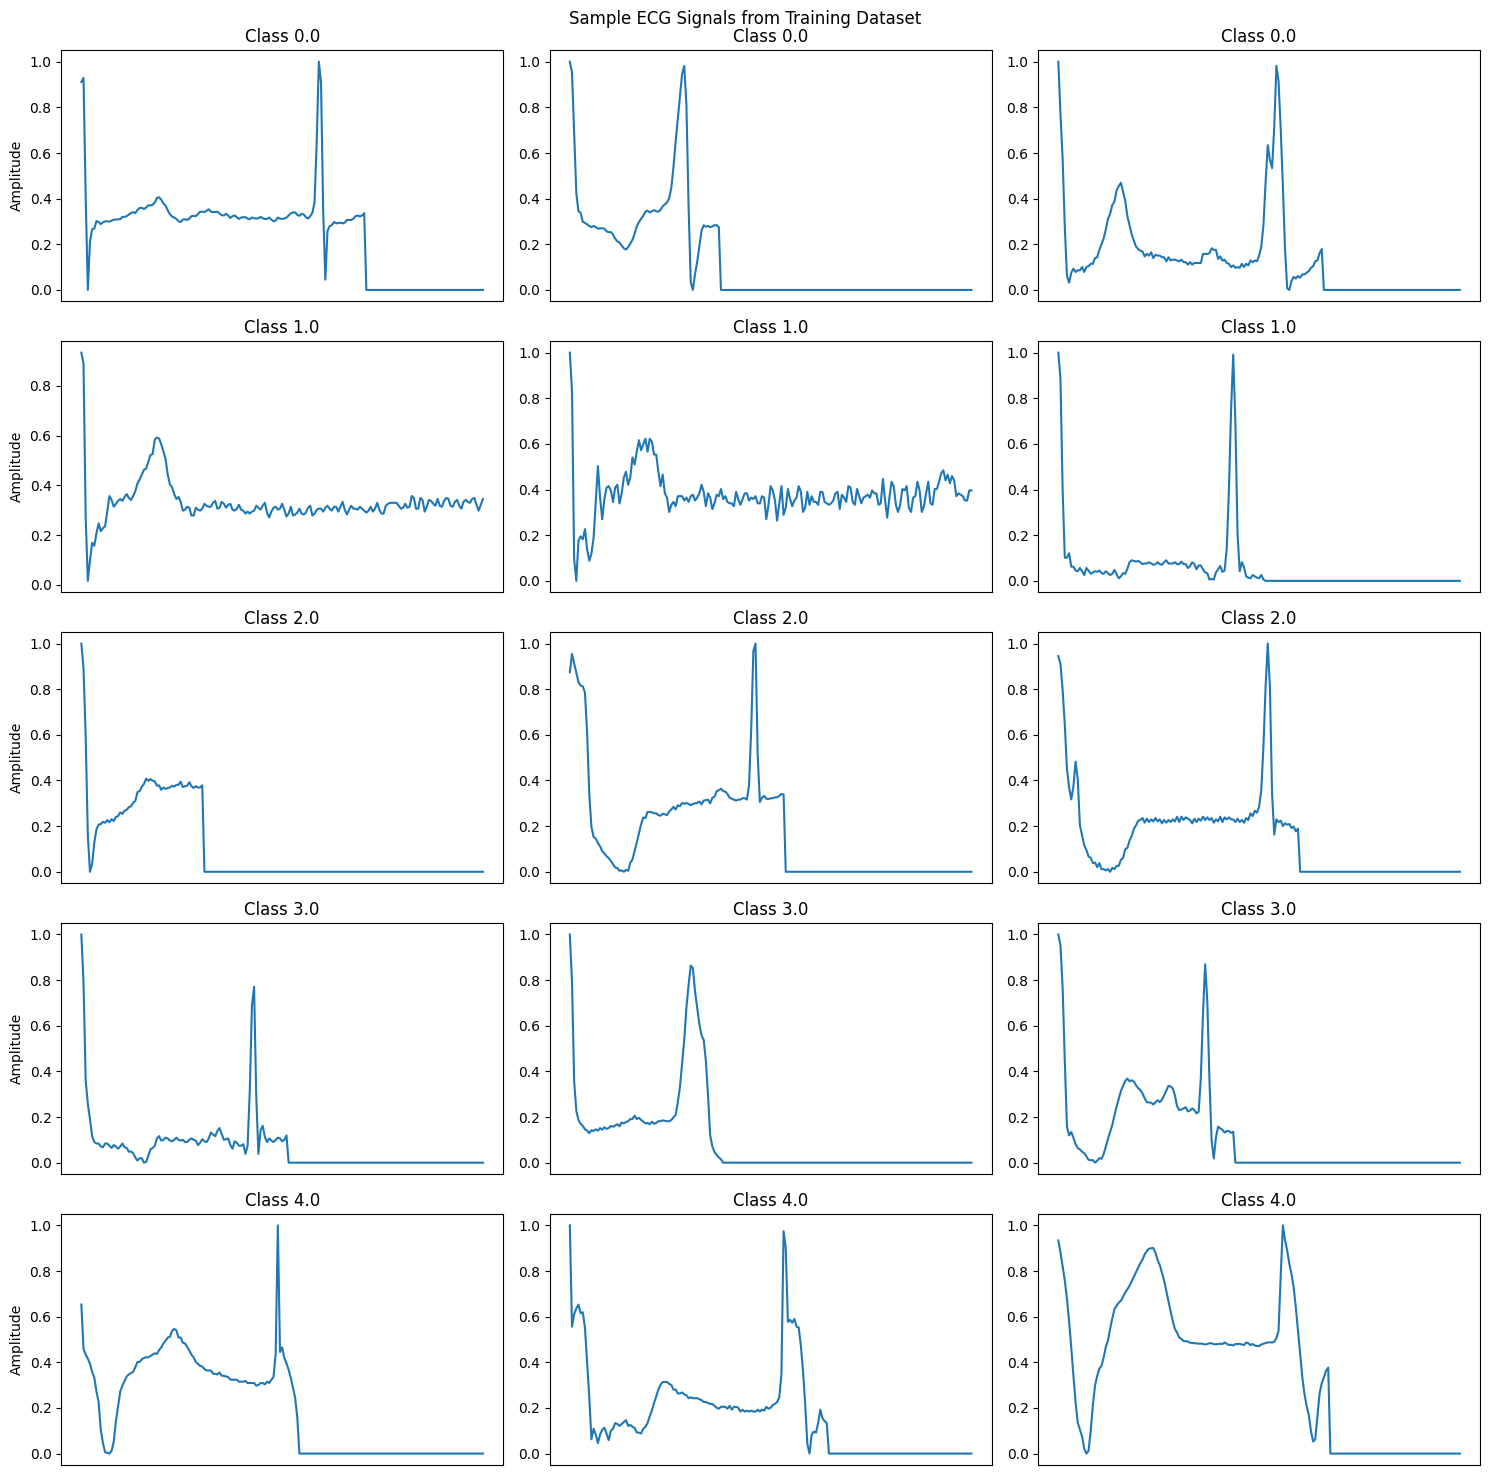


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [5]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Hybrid Model

## training loop

In [6]:
config = get_training_config()
num_classes = int(len(np.unique(y_train)))
sequence_length = int(X_train.shape[1])

for name, section in config.items():
    mp = section.get('model_params', {})
    if 'num_classes' in mp:
        mp['num_classes'] = num_classes
    if 'sequence_length' in mp:
        mp['sequence_length'] = sequence_length
    
    print(f"Updated configuration: {name}")
    print(f"Number of classes: {num_classes}")
    print(f"Sequence length: {sequence_length}")

Updated configuration: CNN-RNN
Number of classes: 5
Sequence length: 187
Updated configuration: GRU
Number of classes: 5
Sequence length: 187


In [7]:
model_name = 'CNN-RNN'
model_params = config[model_name]['model_params']

hybrid_model = ECG_CNN_RNN(**model_params)

Using device: cuda

Starting training for CNN-RNN...


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.01it/s]



Epoch [1/100]
Train Loss: 0.7967, Train Acc: 81.20%
Val Loss: 0.6682, Val Acc: 82.00%
Learning Rate: 0.000105


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.66it/s]



Epoch [2/100]
Train Loss: 0.4647, Train Acc: 91.84%
Val Loss: 0.3671, Val Acc: 95.15%
Learning Rate: 0.000204


Training: 100%|██████████| 2463/2463 [00:37<00:00, 64.82it/s]



Epoch [3/100]
Train Loss: 0.3800, Train Acc: 94.91%
Val Loss: 0.3326, Val Acc: 96.33%
Learning Rate: 0.000304


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.58it/s]



Epoch [4/100]
Train Loss: 0.3560, Train Acc: 95.71%
Val Loss: 0.3221, Val Acc: 96.57%
Learning Rate: 0.000403


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.56it/s]



Epoch [5/100]
Train Loss: 0.3388, Train Acc: 96.29%
Val Loss: 0.3064, Val Acc: 97.17%
Learning Rate: 0.000503


Training: 100%|██████████| 2463/2463 [00:38<00:00, 63.73it/s]



Epoch [6/100]
Train Loss: 0.3257, Train Acc: 96.81%
Val Loss: 0.2999, Val Acc: 97.27%
Learning Rate: 0.000602


Training: 100%|██████████| 2463/2463 [00:41<00:00, 59.57it/s]



Epoch [7/100]
Train Loss: 0.3175, Train Acc: 96.96%
Val Loss: 0.2971, Val Acc: 97.32%
Learning Rate: 0.000701


Training: 100%|██████████| 2463/2463 [00:41<00:00, 59.49it/s]



Epoch [8/100]
Train Loss: 0.3100, Train Acc: 97.19%
Val Loss: 0.2946, Val Acc: 97.53%
Learning Rate: 0.000801


Training: 100%|██████████| 2463/2463 [00:41<00:00, 59.92it/s]



Epoch [9/100]
Train Loss: 0.3024, Train Acc: 97.43%
Val Loss: 0.2917, Val Acc: 97.54%
Learning Rate: 0.000901


Training: 100%|██████████| 2463/2463 [00:40<00:00, 61.33it/s]



Epoch [10/100]
Train Loss: 0.2978, Train Acc: 97.53%
Val Loss: 0.2796, Val Acc: 97.99%
Learning Rate: 0.001000


Training: 100%|██████████| 2463/2463 [00:38<00:00, 63.73it/s]



Epoch [11/100]
Train Loss: 0.2939, Train Acc: 97.60%
Val Loss: 0.2794, Val Acc: 97.91%
Learning Rate: 0.001000


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.14it/s]



Epoch [12/100]
Train Loss: 0.2871, Train Acc: 97.82%
Val Loss: 0.2841, Val Acc: 97.77%
Learning Rate: 0.000999


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.32it/s]



Epoch [13/100]
Train Loss: 0.2837, Train Acc: 97.93%
Val Loss: 0.2764, Val Acc: 98.16%
Learning Rate: 0.000997


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.30it/s]



Epoch [14/100]
Train Loss: 0.2792, Train Acc: 98.12%
Val Loss: 0.2707, Val Acc: 98.32%
Learning Rate: 0.000995


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.10it/s]



Epoch [15/100]
Train Loss: 0.2734, Train Acc: 98.28%
Val Loss: 0.2739, Val Acc: 98.24%
Learning Rate: 0.000992


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.25it/s]



Epoch [16/100]
Train Loss: 0.2726, Train Acc: 98.33%
Val Loss: 0.2665, Val Acc: 98.44%
Learning Rate: 0.000989


Training: 100%|██████████| 2463/2463 [00:41<00:00, 59.80it/s]



Epoch [17/100]
Train Loss: 0.2689, Train Acc: 98.46%
Val Loss: 0.2702, Val Acc: 98.30%
Learning Rate: 0.000985


Training: 100%|██████████| 2463/2463 [00:41<00:00, 59.56it/s]



Epoch [18/100]
Train Loss: 0.2679, Train Acc: 98.46%
Val Loss: 0.2707, Val Acc: 98.29%
Learning Rate: 0.000981


Training: 100%|██████████| 2463/2463 [00:40<00:00, 60.71it/s]



Epoch [19/100]
Train Loss: 0.2641, Train Acc: 98.58%
Val Loss: 0.2699, Val Acc: 98.33%
Learning Rate: 0.000976


Training: 100%|██████████| 2463/2463 [00:38<00:00, 63.81it/s]



Epoch [20/100]
Train Loss: 0.2640, Train Acc: 98.58%
Val Loss: 0.2659, Val Acc: 98.48%
Learning Rate: 0.000970


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.39it/s]



Epoch [21/100]
Train Loss: 0.2617, Train Acc: 98.67%
Val Loss: 0.2674, Val Acc: 98.36%
Learning Rate: 0.000964


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.42it/s]



Epoch [22/100]
Train Loss: 0.2614, Train Acc: 98.67%
Val Loss: 0.2667, Val Acc: 98.44%
Learning Rate: 0.000957


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.75it/s]



Epoch [23/100]
Train Loss: 0.2596, Train Acc: 98.75%
Val Loss: 0.2668, Val Acc: 98.53%
Learning Rate: 0.000950


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.22it/s]



Epoch [24/100]
Train Loss: 0.2578, Train Acc: 98.78%
Val Loss: 0.2636, Val Acc: 98.55%
Learning Rate: 0.000942


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.18it/s]



Epoch [25/100]
Train Loss: 0.2559, Train Acc: 98.84%
Val Loss: 0.2663, Val Acc: 98.54%
Learning Rate: 0.000933


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.58it/s]



Epoch [26/100]
Train Loss: 0.2563, Train Acc: 98.86%
Val Loss: 0.2651, Val Acc: 98.54%
Learning Rate: 0.000924


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.51it/s]



Epoch [27/100]
Train Loss: 0.2549, Train Acc: 98.90%
Val Loss: 0.2650, Val Acc: 98.50%
Learning Rate: 0.000915


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.48it/s]



Epoch [28/100]
Train Loss: 0.2532, Train Acc: 98.95%
Val Loss: 0.2680, Val Acc: 98.37%
Learning Rate: 0.000905


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.51it/s]



Epoch [29/100]
Train Loss: 0.2521, Train Acc: 99.00%
Val Loss: 0.2640, Val Acc: 98.58%
Learning Rate: 0.000895


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.51it/s]



Epoch [30/100]
Train Loss: 0.2519, Train Acc: 98.97%
Val Loss: 0.2635, Val Acc: 98.53%
Learning Rate: 0.000884


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.34it/s]



Epoch [31/100]
Train Loss: 0.2502, Train Acc: 99.03%
Val Loss: 0.2595, Val Acc: 98.76%
Learning Rate: 0.000872


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.74it/s]



Epoch [32/100]
Train Loss: 0.2502, Train Acc: 99.05%
Val Loss: 0.2593, Val Acc: 98.68%
Learning Rate: 0.000860


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.30it/s]



Epoch [33/100]
Train Loss: 0.2489, Train Acc: 99.08%
Val Loss: 0.2621, Val Acc: 98.70%
Learning Rate: 0.000848


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.81it/s]



Epoch [34/100]
Train Loss: 0.2489, Train Acc: 99.10%
Val Loss: 0.2611, Val Acc: 98.64%
Learning Rate: 0.000835


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.14it/s]



Epoch [35/100]
Train Loss: 0.2481, Train Acc: 99.12%
Val Loss: 0.2615, Val Acc: 98.65%
Learning Rate: 0.000822


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.32it/s]



Epoch [36/100]
Train Loss: 0.2477, Train Acc: 99.12%
Val Loss: 0.2611, Val Acc: 98.66%
Learning Rate: 0.000809


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.27it/s]



Epoch [37/100]
Train Loss: 0.2448, Train Acc: 99.24%
Val Loss: 0.2639, Val Acc: 98.65%
Learning Rate: 0.000795


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.38it/s]



Epoch [38/100]
Train Loss: 0.2458, Train Acc: 99.21%
Val Loss: 0.2609, Val Acc: 98.76%
Learning Rate: 0.000781


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.28it/s]



Epoch [39/100]
Train Loss: 0.2450, Train Acc: 99.23%
Val Loss: 0.2634, Val Acc: 98.57%
Learning Rate: 0.000766


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.57it/s]



Epoch [40/100]
Train Loss: 0.2438, Train Acc: 99.27%
Val Loss: 0.2607, Val Acc: 98.70%
Learning Rate: 0.000751


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.53it/s]



Epoch [41/100]
Train Loss: 0.2431, Train Acc: 99.29%
Val Loss: 0.2637, Val Acc: 98.58%
Learning Rate: 0.000736


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.64it/s]



Epoch [42/100]
Train Loss: 0.2420, Train Acc: 99.35%
Val Loss: 0.2611, Val Acc: 98.66%
Learning Rate: 0.000721


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.14it/s]



Epoch [43/100]
Train Loss: 0.2415, Train Acc: 99.38%
Val Loss: 0.2595, Val Acc: 98.79%
Learning Rate: 0.000705


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.48it/s]



Epoch [44/100]
Train Loss: 0.2413, Train Acc: 99.38%
Val Loss: 0.2613, Val Acc: 98.74%
Learning Rate: 0.000689


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.15it/s]



Epoch [45/100]
Train Loss: 0.2405, Train Acc: 99.39%
Val Loss: 0.2615, Val Acc: 98.77%
Learning Rate: 0.000673


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.36it/s]



Epoch [46/100]
Train Loss: 0.2398, Train Acc: 99.42%
Val Loss: 0.2595, Val Acc: 98.74%
Learning Rate: 0.000656


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.27it/s]



Epoch [47/100]
Train Loss: 0.2396, Train Acc: 99.44%
Val Loss: 0.2593, Val Acc: 98.73%
Learning Rate: 0.000640


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.36it/s]



Epoch [48/100]
Train Loss: 0.2390, Train Acc: 99.47%
Val Loss: 0.2584, Val Acc: 98.86%
Learning Rate: 0.000623


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.22it/s]



Epoch [49/100]
Train Loss: 0.2388, Train Acc: 99.44%
Val Loss: 0.2631, Val Acc: 98.69%
Learning Rate: 0.000606


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.40it/s]



Epoch [50/100]
Train Loss: 0.2374, Train Acc: 99.51%
Val Loss: 0.2607, Val Acc: 98.74%
Learning Rate: 0.000589


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.35it/s]



Epoch [51/100]
Train Loss: 0.2378, Train Acc: 99.49%
Val Loss: 0.2585, Val Acc: 98.74%
Learning Rate: 0.000572


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.48it/s]



Epoch [52/100]
Train Loss: 0.2370, Train Acc: 99.53%
Val Loss: 0.2583, Val Acc: 98.82%
Learning Rate: 0.000555


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.19it/s]



Epoch [53/100]
Train Loss: 0.2371, Train Acc: 99.54%
Val Loss: 0.2577, Val Acc: 98.85%
Learning Rate: 0.000537


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.51it/s]



Epoch [54/100]
Train Loss: 0.2355, Train Acc: 99.57%
Val Loss: 0.2620, Val Acc: 98.71%
Learning Rate: 0.000520


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.16it/s]



Epoch [55/100]
Train Loss: 0.2350, Train Acc: 99.62%
Val Loss: 0.2627, Val Acc: 98.58%
Learning Rate: 0.000503


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.19it/s]



Epoch [56/100]
Train Loss: 0.2356, Train Acc: 99.58%
Val Loss: 0.2635, Val Acc: 98.64%
Learning Rate: 0.000485


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.28it/s]



Epoch [57/100]
Train Loss: 0.2350, Train Acc: 99.61%
Val Loss: 0.2621, Val Acc: 98.70%
Learning Rate: 0.000468


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.34it/s]



Epoch [58/100]
Train Loss: 0.2337, Train Acc: 99.67%
Val Loss: 0.2607, Val Acc: 98.85%
Learning Rate: 0.000450


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.22it/s]



Epoch [59/100]
Train Loss: 0.2336, Train Acc: 99.65%
Val Loss: 0.2621, Val Acc: 98.70%
Learning Rate: 0.000433


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.46it/s]



Epoch [60/100]
Train Loss: 0.2334, Train Acc: 99.67%
Val Loss: 0.2589, Val Acc: 98.80%
Learning Rate: 0.000416


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.30it/s]



Epoch [61/100]
Train Loss: 0.2329, Train Acc: 99.70%
Val Loss: 0.2600, Val Acc: 98.84%
Learning Rate: 0.000399


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.62it/s]



Epoch [62/100]
Train Loss: 0.2329, Train Acc: 99.70%
Val Loss: 0.2585, Val Acc: 98.79%
Learning Rate: 0.000382


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.39it/s]



Epoch [63/100]
Train Loss: 0.2332, Train Acc: 99.67%
Val Loss: 0.2617, Val Acc: 98.70%
Learning Rate: 0.000365


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.53it/s]



Epoch [64/100]
Train Loss: 0.2324, Train Acc: 99.70%
Val Loss: 0.2580, Val Acc: 98.85%
Learning Rate: 0.000349


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.01it/s]



Epoch [65/100]
Train Loss: 0.2320, Train Acc: 99.70%
Val Loss: 0.2605, Val Acc: 98.77%
Learning Rate: 0.000332


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.34it/s]



Epoch [66/100]
Train Loss: 0.2315, Train Acc: 99.74%
Val Loss: 0.2619, Val Acc: 98.73%
Learning Rate: 0.000316


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.41it/s]



Epoch [67/100]
Train Loss: 0.2316, Train Acc: 99.73%
Val Loss: 0.2627, Val Acc: 98.77%
Learning Rate: 0.000300


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.32it/s]



Epoch [68/100]
Train Loss: 0.2309, Train Acc: 99.78%
Val Loss: 0.2606, Val Acc: 98.81%
Learning Rate: 0.000284


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.05it/s]



Epoch [69/100]
Train Loss: 0.2309, Train Acc: 99.77%
Val Loss: 0.2621, Val Acc: 98.80%
Learning Rate: 0.000269


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.26it/s]



Epoch [70/100]
Train Loss: 0.2309, Train Acc: 99.76%
Val Loss: 0.2633, Val Acc: 98.74%
Learning Rate: 0.000254


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.46it/s]



Epoch [71/100]
Train Loss: 0.2302, Train Acc: 99.79%
Val Loss: 0.2644, Val Acc: 98.69%
Learning Rate: 0.000239


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.51it/s]



Epoch [72/100]
Train Loss: 0.2302, Train Acc: 99.79%
Val Loss: 0.2648, Val Acc: 98.69%
Learning Rate: 0.000224


Training: 100%|██████████| 2463/2463 [00:38<00:00, 64.64it/s]


Early stopping triggered at epoch 73
Restored best model from early stopper


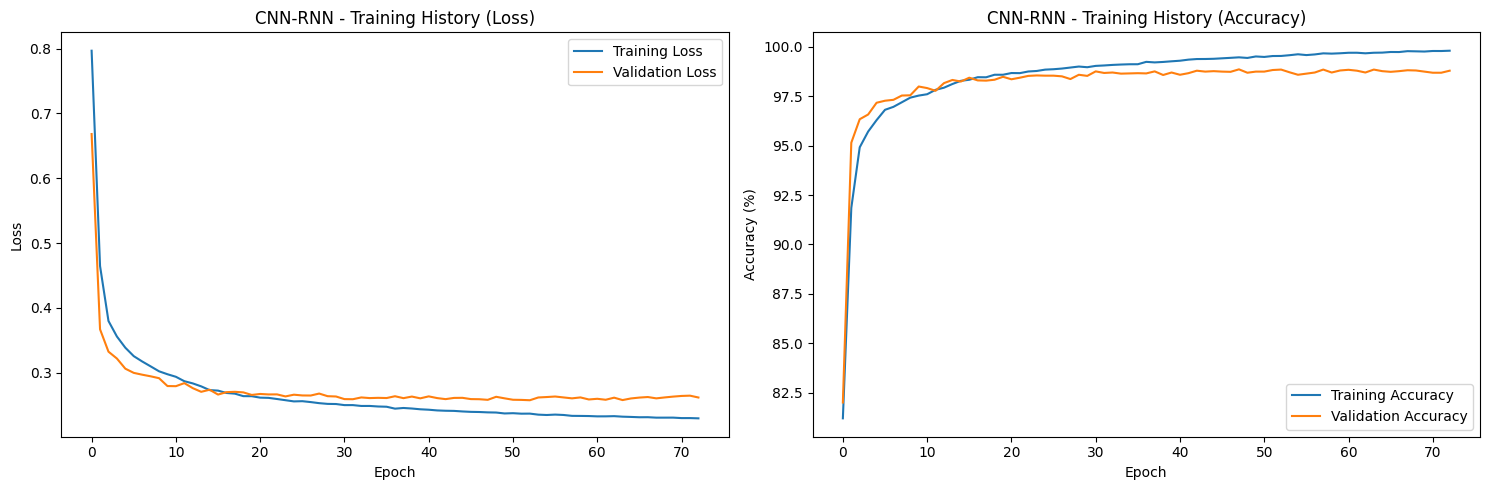

Testing: 100%|██████████| 685/685 [00:02<00:00, 232.14it/s]



Classification Report (CNN-RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.90      0.85      0.88       556
           2       0.98      0.97      0.97      1448
           3       0.87      0.83      0.85       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.93      0.94     21892
weighted avg       0.99      0.99      0.99     21892



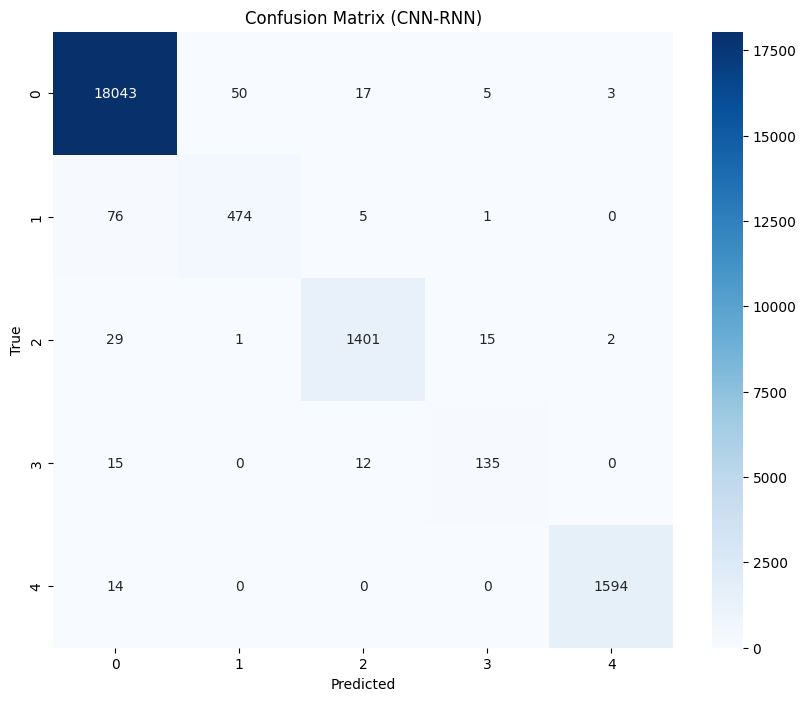

In [8]:
# Train models
hybrid_trainer = train_model(hybrid_model, train_loader, val_loader, test_loader)

## Evaluation Loop

In [ ]:
# Get accuracies
accuracy = get_test_accuracy(hybrid_trainer.model, test_loader, model_name)

print("\nSummary:")
print(f"{hybrid_model.model_name} Test Accuracy: {accuracy:.2f}%")


Evaluating CNN-RNN model...
CNN-RNN Test Accuracy: 98.88%

Summary:
CNN-RNN Test Accuracy: 98.88%


# GRU Model

## Training Loop

In [10]:
# Create model instance
model_name = 'GRU'
model_params = config[model_name]['model_params']

#gru_model = AttentionRNN(**model_params).to(device)
gru_model = AttentionRNN(**model_params)

Using device: cuda

Starting training for GRU...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.65it/s]



Epoch [1/100]
Train Loss: 1.1378, Train Acc: 74.64%
Val Loss: 0.9845, Val Acc: 83.35%
Learning Rate: 0.000105


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.92it/s]



Epoch [2/100]
Train Loss: 0.5888, Train Acc: 89.13%
Val Loss: 0.4163, Val Acc: 93.46%
Learning Rate: 0.000204


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.07it/s]



Epoch [3/100]
Train Loss: 0.4020, Train Acc: 94.13%
Val Loss: 0.3504, Val Acc: 95.41%
Learning Rate: 0.000304


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.39it/s]



Epoch [4/100]
Train Loss: 0.3598, Train Acc: 95.51%
Val Loss: 0.3361, Val Acc: 95.83%
Learning Rate: 0.000403


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.68it/s]



Epoch [5/100]
Train Loss: 0.3358, Train Acc: 96.45%
Val Loss: 0.3085, Val Acc: 97.26%
Learning Rate: 0.000503


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.46it/s]



Epoch [6/100]
Train Loss: 0.3176, Train Acc: 97.06%
Val Loss: 0.3043, Val Acc: 97.33%
Learning Rate: 0.000602


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.89it/s]



Epoch [7/100]
Train Loss: 0.3056, Train Acc: 97.40%
Val Loss: 0.2957, Val Acc: 97.53%
Learning Rate: 0.000701


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.36it/s]



Epoch [8/100]
Train Loss: 0.2983, Train Acc: 97.74%
Val Loss: 0.2922, Val Acc: 97.75%
Learning Rate: 0.000801


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.93it/s]



Epoch [9/100]
Train Loss: 0.2920, Train Acc: 97.88%
Val Loss: 0.2800, Val Acc: 98.04%
Learning Rate: 0.000901


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.91it/s]



Epoch [10/100]
Train Loss: 0.2878, Train Acc: 98.01%
Val Loss: 0.2854, Val Acc: 98.08%
Learning Rate: 0.001000


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.22it/s]



Epoch [11/100]
Train Loss: 0.2824, Train Acc: 98.19%
Val Loss: 0.2718, Val Acc: 98.36%
Learning Rate: 0.001000


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.05it/s]



Epoch [12/100]
Train Loss: 0.2775, Train Acc: 98.29%
Val Loss: 0.2722, Val Acc: 98.33%
Learning Rate: 0.000999


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.32it/s]



Epoch [13/100]
Train Loss: 0.2738, Train Acc: 98.43%
Val Loss: 0.2753, Val Acc: 98.14%
Learning Rate: 0.000997


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.34it/s]



Epoch [14/100]
Train Loss: 0.2703, Train Acc: 98.54%
Val Loss: 0.2630, Val Acc: 98.62%
Learning Rate: 0.000995


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.90it/s]



Epoch [15/100]
Train Loss: 0.2671, Train Acc: 98.66%
Val Loss: 0.2723, Val Acc: 98.34%
Learning Rate: 0.000992


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.79it/s]



Epoch [16/100]
Train Loss: 0.2654, Train Acc: 98.69%
Val Loss: 0.2635, Val Acc: 98.65%
Learning Rate: 0.000989


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.06it/s]



Epoch [17/100]
Train Loss: 0.2634, Train Acc: 98.76%
Val Loss: 0.2680, Val Acc: 98.45%
Learning Rate: 0.000985


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.05it/s]



Epoch [18/100]
Train Loss: 0.2610, Train Acc: 98.85%
Val Loss: 0.2649, Val Acc: 98.54%
Learning Rate: 0.000981


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.95it/s]



Epoch [19/100]
Train Loss: 0.2597, Train Acc: 98.87%
Val Loss: 0.2650, Val Acc: 98.66%
Learning Rate: 0.000976


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.63it/s]



Epoch [20/100]
Train Loss: 0.2583, Train Acc: 98.92%
Val Loss: 0.2619, Val Acc: 98.70%
Learning Rate: 0.000970


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.68it/s]



Epoch [21/100]
Train Loss: 0.2571, Train Acc: 98.97%
Val Loss: 0.2646, Val Acc: 98.65%
Learning Rate: 0.000964


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.77it/s]



Epoch [22/100]
Train Loss: 0.2559, Train Acc: 99.00%
Val Loss: 0.2670, Val Acc: 98.55%
Learning Rate: 0.000957


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.46it/s]



Epoch [23/100]
Train Loss: 0.2543, Train Acc: 99.05%
Val Loss: 0.2634, Val Acc: 98.81%
Learning Rate: 0.000950


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.01it/s]



Epoch [24/100]
Train Loss: 0.2531, Train Acc: 99.06%
Val Loss: 0.2623, Val Acc: 98.61%
Learning Rate: 0.000942


Training: 100%|██████████| 2463/2463 [00:13<00:00, 189.17it/s]



Epoch [25/100]
Train Loss: 0.2527, Train Acc: 99.09%
Val Loss: 0.2585, Val Acc: 98.78%
Learning Rate: 0.000933


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.66it/s]



Epoch [26/100]
Train Loss: 0.2512, Train Acc: 99.16%
Val Loss: 0.2598, Val Acc: 98.64%
Learning Rate: 0.000924


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.07it/s]



Epoch [27/100]
Train Loss: 0.2507, Train Acc: 99.14%
Val Loss: 0.2618, Val Acc: 98.65%
Learning Rate: 0.000915


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.98it/s]



Epoch [28/100]
Train Loss: 0.2496, Train Acc: 99.19%
Val Loss: 0.2615, Val Acc: 98.81%
Learning Rate: 0.000905


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.68it/s]



Epoch [29/100]
Train Loss: 0.2478, Train Acc: 99.25%
Val Loss: 0.2622, Val Acc: 98.73%
Learning Rate: 0.000895


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.86it/s]



Epoch [30/100]
Train Loss: 0.2481, Train Acc: 99.23%
Val Loss: 0.2632, Val Acc: 98.64%
Learning Rate: 0.000884


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.93it/s]



Epoch [31/100]
Train Loss: 0.2474, Train Acc: 99.27%
Val Loss: 0.2596, Val Acc: 98.78%
Learning Rate: 0.000872


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.73it/s]



Epoch [32/100]
Train Loss: 0.2467, Train Acc: 99.28%
Val Loss: 0.2611, Val Acc: 98.74%
Learning Rate: 0.000860


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.35it/s]



Epoch [33/100]
Train Loss: 0.2459, Train Acc: 99.34%
Val Loss: 0.2589, Val Acc: 98.95%
Learning Rate: 0.000848


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.03it/s]



Epoch [34/100]
Train Loss: 0.2447, Train Acc: 99.36%
Val Loss: 0.2599, Val Acc: 98.79%
Learning Rate: 0.000835


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.55it/s]



Epoch [35/100]
Train Loss: 0.2446, Train Acc: 99.38%
Val Loss: 0.2576, Val Acc: 98.73%
Learning Rate: 0.000822


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.86it/s]



Epoch [36/100]
Train Loss: 0.2440, Train Acc: 99.42%
Val Loss: 0.2607, Val Acc: 98.84%
Learning Rate: 0.000809


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.96it/s]



Epoch [37/100]
Train Loss: 0.2437, Train Acc: 99.39%
Val Loss: 0.2602, Val Acc: 98.78%
Learning Rate: 0.000795


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.59it/s]



Epoch [38/100]
Train Loss: 0.2434, Train Acc: 99.43%
Val Loss: 0.2584, Val Acc: 98.77%
Learning Rate: 0.000781


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.22it/s]



Epoch [39/100]
Train Loss: 0.2421, Train Acc: 99.46%
Val Loss: 0.2639, Val Acc: 98.71%
Learning Rate: 0.000766


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.65it/s]



Epoch [40/100]
Train Loss: 0.2413, Train Acc: 99.51%
Val Loss: 0.2618, Val Acc: 98.77%
Learning Rate: 0.000751


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.39it/s]



Epoch [41/100]
Train Loss: 0.2407, Train Acc: 99.50%
Val Loss: 0.2646, Val Acc: 98.63%
Learning Rate: 0.000736


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.38it/s]



Epoch [42/100]
Train Loss: 0.2398, Train Acc: 99.54%
Val Loss: 0.2640, Val Acc: 98.78%
Learning Rate: 0.000721


Training: 100%|██████████| 2463/2463 [00:12<00:00, 196.01it/s]



Epoch [43/100]
Train Loss: 0.2397, Train Acc: 99.54%
Val Loss: 0.2596, Val Acc: 98.71%
Learning Rate: 0.000705


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.01it/s]



Epoch [44/100]
Train Loss: 0.2384, Train Acc: 99.59%
Val Loss: 0.2572, Val Acc: 98.80%
Learning Rate: 0.000689


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.53it/s]



Epoch [45/100]
Train Loss: 0.2393, Train Acc: 99.57%
Val Loss: 0.2585, Val Acc: 98.87%
Learning Rate: 0.000673


Training: 100%|██████████| 2463/2463 [00:12<00:00, 195.24it/s]



Epoch [46/100]
Train Loss: 0.2386, Train Acc: 99.58%
Val Loss: 0.2584, Val Acc: 98.85%
Learning Rate: 0.000656


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.72it/s]



Epoch [47/100]
Train Loss: 0.2373, Train Acc: 99.65%
Val Loss: 0.2568, Val Acc: 98.89%
Learning Rate: 0.000640


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.65it/s]



Epoch [48/100]
Train Loss: 0.2371, Train Acc: 99.64%
Val Loss: 0.2586, Val Acc: 98.78%
Learning Rate: 0.000623


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.23it/s]



Epoch [49/100]
Train Loss: 0.2367, Train Acc: 99.65%
Val Loss: 0.2627, Val Acc: 98.65%
Learning Rate: 0.000606


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.74it/s]



Epoch [50/100]
Train Loss: 0.2362, Train Acc: 99.67%
Val Loss: 0.2634, Val Acc: 98.81%
Learning Rate: 0.000589


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.73it/s]



Epoch [51/100]
Train Loss: 0.2359, Train Acc: 99.70%
Val Loss: 0.2598, Val Acc: 98.89%
Learning Rate: 0.000572


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.42it/s]



Epoch [52/100]
Train Loss: 0.2362, Train Acc: 99.67%
Val Loss: 0.2583, Val Acc: 98.78%
Learning Rate: 0.000555


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.02it/s]



Epoch [53/100]
Train Loss: 0.2351, Train Acc: 99.72%
Val Loss: 0.2565, Val Acc: 98.97%
Learning Rate: 0.000537


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.98it/s]



Epoch [54/100]
Train Loss: 0.2349, Train Acc: 99.72%
Val Loss: 0.2603, Val Acc: 98.89%
Learning Rate: 0.000520


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.78it/s]



Epoch [55/100]
Train Loss: 0.2347, Train Acc: 99.71%
Val Loss: 0.2626, Val Acc: 98.76%
Learning Rate: 0.000503


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.98it/s]



Epoch [56/100]
Train Loss: 0.2340, Train Acc: 99.76%
Val Loss: 0.2568, Val Acc: 98.95%
Learning Rate: 0.000485


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.98it/s]



Epoch [57/100]
Train Loss: 0.2338, Train Acc: 99.77%
Val Loss: 0.2601, Val Acc: 98.94%
Learning Rate: 0.000468


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.53it/s]



Epoch [58/100]
Train Loss: 0.2338, Train Acc: 99.76%
Val Loss: 0.2606, Val Acc: 98.88%
Learning Rate: 0.000450


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.35it/s]



Epoch [59/100]
Train Loss: 0.2332, Train Acc: 99.77%
Val Loss: 0.2608, Val Acc: 98.85%
Learning Rate: 0.000433


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.42it/s]



Epoch [60/100]
Train Loss: 0.2323, Train Acc: 99.81%
Val Loss: 0.2591, Val Acc: 98.88%
Learning Rate: 0.000416


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.45it/s]



Epoch [61/100]
Train Loss: 0.2326, Train Acc: 99.80%
Val Loss: 0.2605, Val Acc: 98.87%
Learning Rate: 0.000399


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.52it/s]



Epoch [62/100]
Train Loss: 0.2314, Train Acc: 99.83%
Val Loss: 0.2585, Val Acc: 99.07%
Learning Rate: 0.000382


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.45it/s]



Epoch [63/100]
Train Loss: 0.2314, Train Acc: 99.84%
Val Loss: 0.2602, Val Acc: 98.87%
Learning Rate: 0.000365


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.28it/s]



Epoch [64/100]
Train Loss: 0.2316, Train Acc: 99.84%
Val Loss: 0.2603, Val Acc: 98.93%
Learning Rate: 0.000349


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.22it/s]



Epoch [65/100]
Train Loss: 0.2311, Train Acc: 99.84%
Val Loss: 0.2587, Val Acc: 99.04%
Learning Rate: 0.000332


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.38it/s]



Epoch [66/100]
Train Loss: 0.2304, Train Acc: 99.88%
Val Loss: 0.2585, Val Acc: 98.90%
Learning Rate: 0.000316


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.12it/s]


Early stopping triggered at epoch 67
Restored best model from early stopper


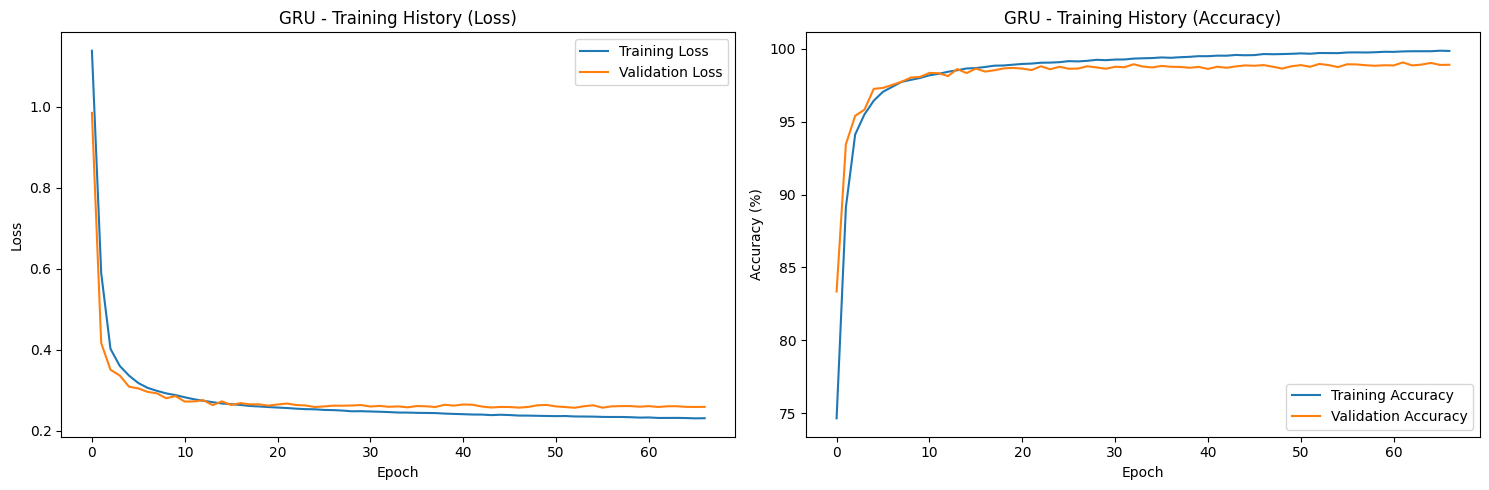

Testing: 100%|██████████| 685/685 [00:01<00:00, 555.82it/s]



Classification Report (GRU):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.92      0.83      0.87       556
           2       0.97      0.97      0.97      1448
           3       0.86      0.81      0.84       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892



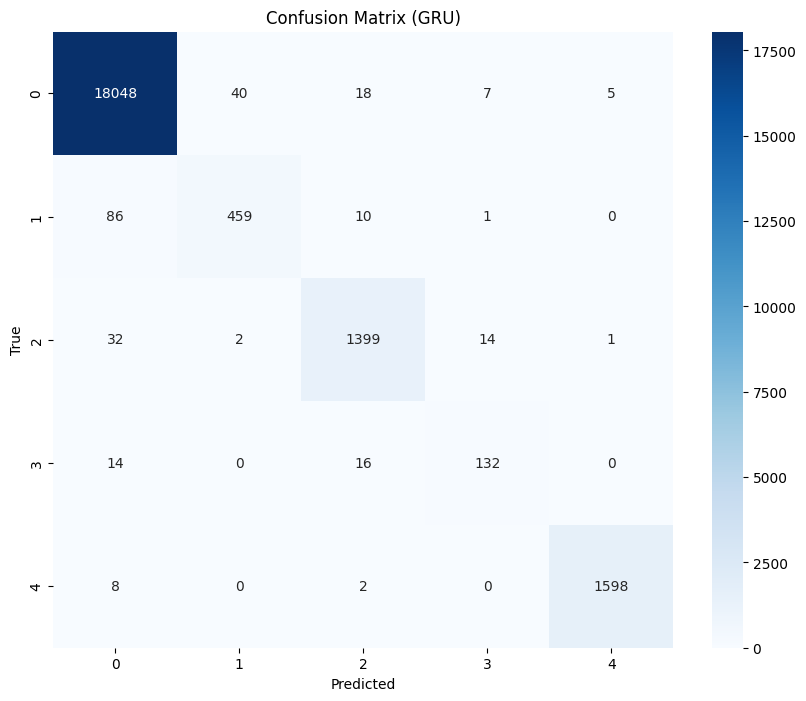

In [11]:
gru_trainer = train_model(gru_model, train_loader, val_loader, test_loader)

## Evaluation Loop

In [ ]:
# Get accuracies
accuracy = get_test_accuracy(gru_trainer.model, test_loader, model_name)

print("\nSummary:")
print(f"{gru_model.model_name} Test Accuracy: {accuracy:.2f}%")


Evaluating GRU model...


GRU Test Accuracy: 98.83%

Summary:
GRU Test Accuracy: 98.83%


# DATA AUGMENTATION PORTION

## data augmentation: using stratified split instead to maintain class distribution

In [ ]:
class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        # Split before applying SMOTE
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Apply SMOTE to training data only
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Reshape for RNN input
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [18]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (326115, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [ ]:
from tsaug import AddNoise, Drift, TimeWarp
import numpy as np

# Define all augmentation methods
def apply_augmentations_separately(X_train):
    
    augmentations = {}
    
    # Additive Noise
    print("\n1. Additive Noise (Gaussian):")
    noise_augmenter = AddNoise(scale=0.01)
    augmentations['noise'] = noise_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['noise'].shape}")
    
    # Baseline Wander (Drift)
    print("\n2. Baseline Wander( Drift):")
    drift_augmenter = Drift(max_drift=0.15, n_drift_points=5)
    augmentations['drift'] = drift_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['drift'].shape}")
    
    # Time Warping
    print("\n3. Time Warping:")
    warp_augmenter = TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    augmentations['warp'] = warp_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['warp'].shape}")
    
    # Combined
    print("\n4. Combined (Additive Noise + Baseline Wander + Time Warping) :")
    combined_augmenter = (
        AddNoise(scale=0.01) +
        Drift(max_drift=0.15, n_drift_points=5) +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    )
    augmentations['combined'] = combined_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['combined'].shape}")
    
    return augmentations

In [ ]:
X_train = (apply_augmentations_separately(X_train))['noise']
X_train


1. Additive Noise (Gaussian):
    Applied: (326115, 187, 1)

2. Baseline Wander( Drift):
    Applied: (326115, 187, 1)

3. Time Warping:
    Applied: (326115, 187, 1)

4. Combined (Additive Noise + Baseline Wander + Time Warping) :
    Applied: (326115, 187, 1)


array([[[ 1.00959360e+00],
        [ 5.66971371e-01],
        [-1.42031950e-02],
        ...,
        [ 7.22687603e-03],
        [-1.21354281e-02],
        [-1.14942550e-02]],

       [[ 9.88193168e-01],
        [ 9.55525755e-01],
        [ 6.79815739e-01],
        ...,
        [ 1.13091220e-03],
        [-1.20141321e-03],
        [-2.68818941e-03]],

       [[ 9.89319335e-01],
        [ 9.73920734e-01],
        [ 8.46794148e-01],
        ...,
        [-1.50758344e-02],
        [ 1.15708487e-02],
        [ 1.34290416e-02]],

       ...,

       [[ 7.62509997e-01],
        [ 5.65421057e-01],
        [ 5.49284753e-01],
        ...,
        [-8.06746814e-03],
        [ 1.26370431e-02],
        [ 1.15935173e-03]],

       [[ 9.30262625e-01],
        [ 8.76603386e-01],
        [ 8.24234447e-01],
        ...,
        [ 2.85672565e-03],
        [ 1.56629676e-02],
        [ 1.07241495e-03]],

       [[ 6.98992168e-01],
        [ 5.58711821e-01],
        [ 4.62969853e-01],
        ...,
        

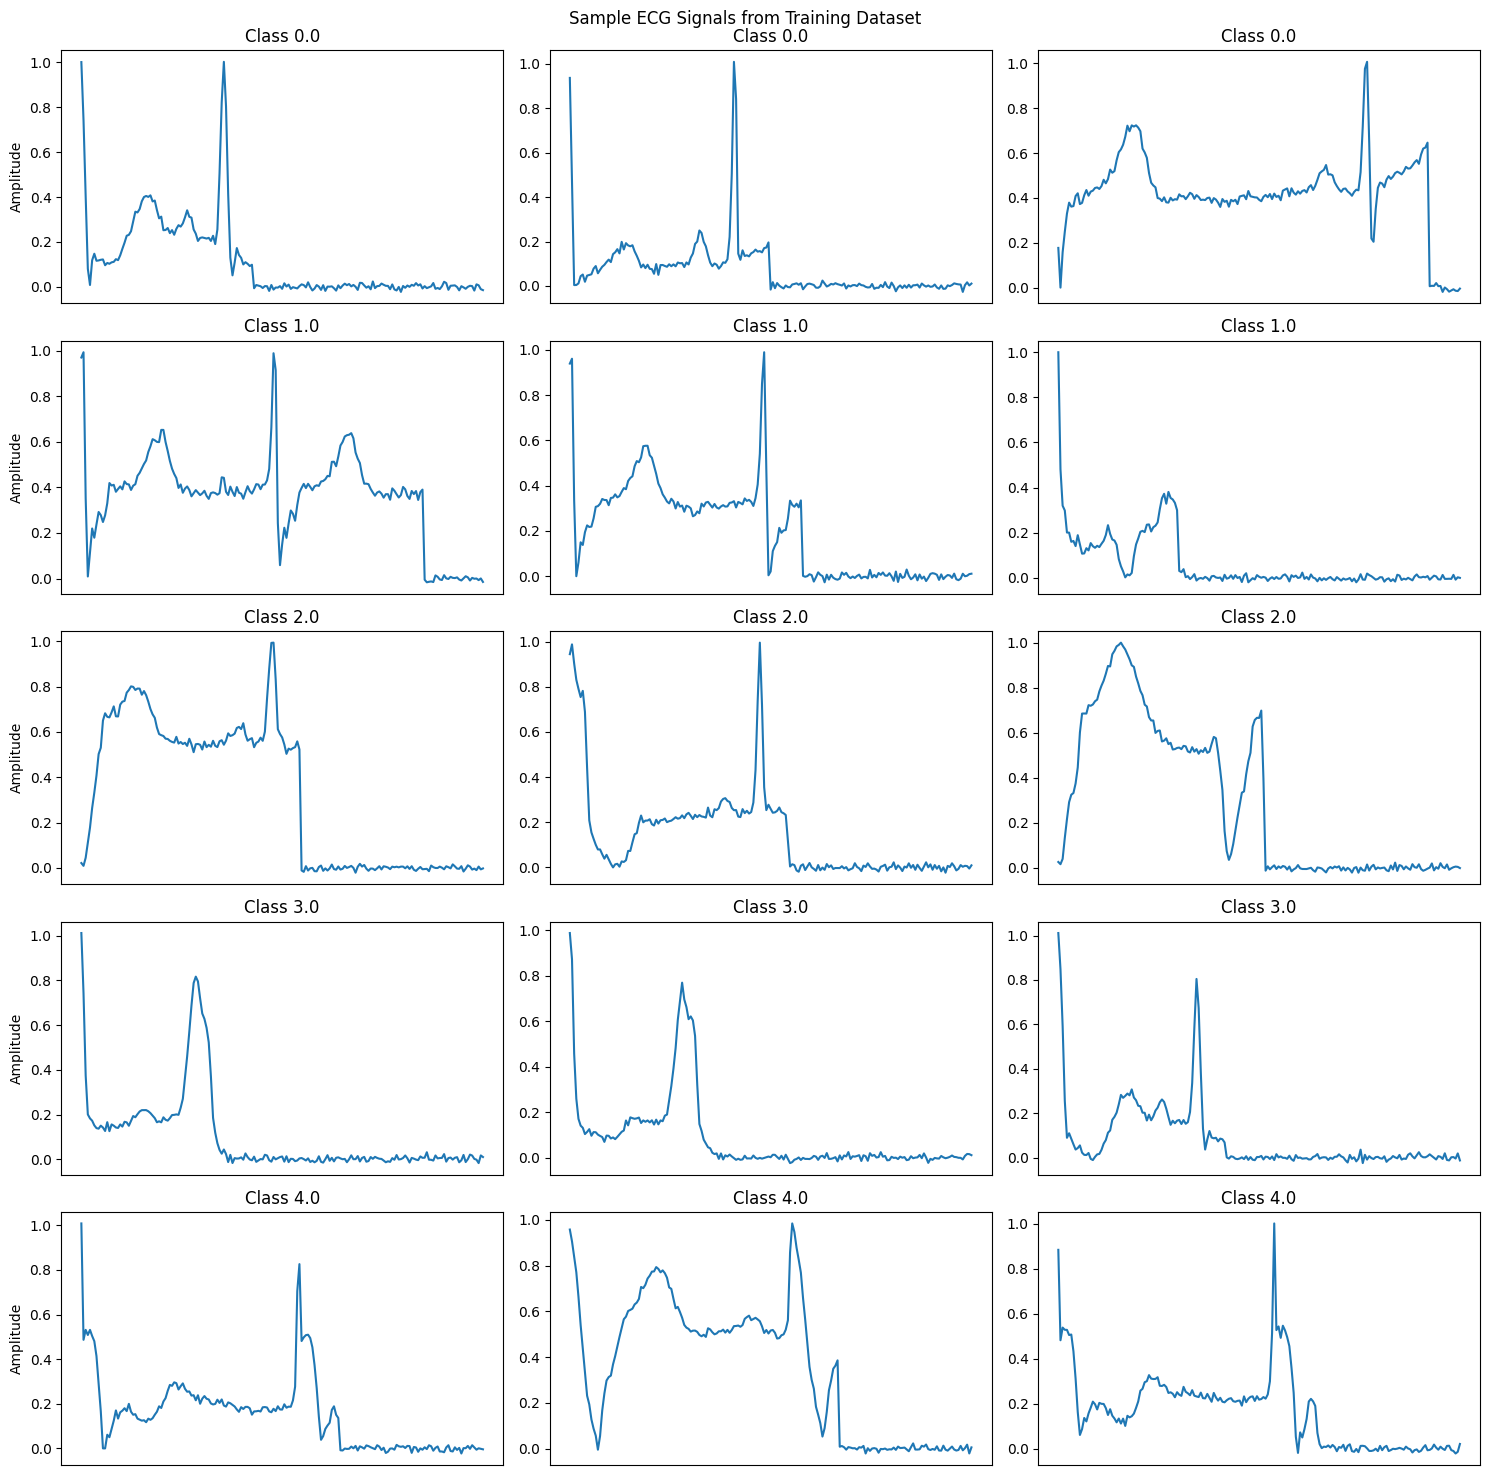


Final dataset sizes:
Training set: (326115, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [ ]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

In [21]:
config = get_training_config()
num_classes = int(len(np.unique(y_train)))
sequence_length = int(X_train.shape[1])

for name, section in config.items():
    mp = section.get('model_params', {})
    if 'num_classes' in mp:
        mp['num_classes'] = num_classes
    if 'sequence_length' in mp:
        mp['sequence_length'] = sequence_length
    
    print(f"Updated configuration: {name}")
    print(f"Number of classes: {num_classes}")
    print(f"Sequence length: {sequence_length}")

Updated configuration: CNN-RNN
Number of classes: 5
Sequence length: 187
Updated configuration: GRU
Number of classes: 5
Sequence length: 187


Using device: cuda

Starting training for CNN-RNN...


Training: 100%|██████████| 10192/10192 [02:55<00:00, 58.14it/s]



Epoch [1/100]
Train Loss: 1.2272, Train Acc: 52.56%
Val Loss: 1.2644, Val Acc: 43.74%
Learning Rate: 0.000105


Training: 100%|██████████| 10192/10192 [02:56<00:00, 57.89it/s]



Epoch [2/100]
Train Loss: 0.4752, Train Acc: 89.56%
Val Loss: 0.4696, Val Acc: 89.60%
Learning Rate: 0.000204


Training: 100%|██████████| 10192/10192 [02:53<00:00, 58.65it/s]



Epoch [3/100]
Train Loss: 0.3519, Train Acc: 94.96%
Val Loss: 0.3442, Val Acc: 95.24%
Learning Rate: 0.000304


Training: 100%|██████████| 10192/10192 [02:55<00:00, 58.22it/s]



Epoch [4/100]
Train Loss: 0.3115, Train Acc: 96.67%
Val Loss: 0.3048, Val Acc: 96.97%
Learning Rate: 0.000403


Training: 100%|██████████| 10192/10192 [02:53<00:00, 58.63it/s]



Epoch [5/100]
Train Loss: 0.2924, Train Acc: 97.48%
Val Loss: 0.3123, Val Acc: 96.63%
Learning Rate: 0.000503


Training: 100%|██████████| 10192/10192 [02:58<00:00, 57.09it/s]



Epoch [6/100]
Train Loss: 0.2814, Train Acc: 97.93%
Val Loss: 0.2987, Val Acc: 97.17%
Learning Rate: 0.000602


Training: 100%|██████████| 10192/10192 [03:19<00:00, 51.16it/s]



Epoch [7/100]
Train Loss: 0.2744, Train Acc: 98.24%
Val Loss: 0.2889, Val Acc: 97.56%
Learning Rate: 0.000701


Training: 100%|██████████| 10192/10192 [03:21<00:00, 50.61it/s]



Epoch [8/100]
Train Loss: 0.2702, Train Acc: 98.41%
Val Loss: 0.3009, Val Acc: 97.10%
Learning Rate: 0.000801


Training: 100%|██████████| 10192/10192 [03:14<00:00, 52.51it/s]



Epoch [9/100]
Train Loss: 0.2671, Train Acc: 98.54%
Val Loss: 0.2895, Val Acc: 97.57%
Learning Rate: 0.000901


Training: 100%|██████████| 10192/10192 [03:25<00:00, 49.57it/s]



Epoch [10/100]
Train Loss: 0.2645, Train Acc: 98.62%
Val Loss: 0.2823, Val Acc: 97.99%
Learning Rate: 0.001000


Training: 100%|██████████| 10192/10192 [03:20<00:00, 50.71it/s]



Epoch [11/100]
Train Loss: 0.2635, Train Acc: 98.67%
Val Loss: 0.2803, Val Acc: 97.82%
Learning Rate: 0.001000


Training: 100%|██████████| 10192/10192 [03:25<00:00, 49.67it/s]



Epoch [12/100]
Train Loss: 0.2603, Train Acc: 98.79%
Val Loss: 0.2777, Val Acc: 98.10%
Learning Rate: 0.000999


Training: 100%|██████████| 10192/10192 [03:09<00:00, 53.73it/s]



Epoch [13/100]
Train Loss: 0.2574, Train Acc: 98.90%
Val Loss: 0.2899, Val Acc: 97.59%
Learning Rate: 0.000997


Training: 100%|██████████| 10192/10192 [02:51<00:00, 59.27it/s]



Epoch [14/100]
Train Loss: 0.2552, Train Acc: 98.97%
Val Loss: 0.2835, Val Acc: 97.82%
Learning Rate: 0.000995


Training: 100%|██████████| 10192/10192 [03:01<00:00, 56.30it/s]



Epoch [15/100]
Train Loss: 0.2539, Train Acc: 99.03%
Val Loss: 0.2721, Val Acc: 98.29%
Learning Rate: 0.000992


Training: 100%|██████████| 10192/10192 [02:49<00:00, 60.23it/s]



Epoch [16/100]
Train Loss: 0.2528, Train Acc: 99.06%
Val Loss: 0.2808, Val Acc: 97.94%
Learning Rate: 0.000989


Training: 100%|██████████| 10192/10192 [02:55<00:00, 58.10it/s]



Epoch [17/100]
Train Loss: 0.2511, Train Acc: 99.14%
Val Loss: 0.2781, Val Acc: 97.92%
Learning Rate: 0.000985


Training: 100%|██████████| 10192/10192 [02:45<00:00, 61.57it/s]



Epoch [18/100]
Train Loss: 0.2505, Train Acc: 99.15%
Val Loss: 0.2830, Val Acc: 97.78%
Learning Rate: 0.000981


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.73it/s]



Epoch [19/100]
Train Loss: 0.2495, Train Acc: 99.20%
Val Loss: 0.2709, Val Acc: 98.17%
Learning Rate: 0.000976


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.57it/s]



Epoch [20/100]
Train Loss: 0.2486, Train Acc: 99.23%
Val Loss: 0.2658, Val Acc: 98.55%
Learning Rate: 0.000970


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.91it/s]



Epoch [21/100]
Train Loss: 0.2483, Train Acc: 99.24%
Val Loss: 0.2775, Val Acc: 98.07%
Learning Rate: 0.000964


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.05it/s]



Epoch [22/100]
Train Loss: 0.2473, Train Acc: 99.28%
Val Loss: 0.2691, Val Acc: 98.48%
Learning Rate: 0.000957


Training: 100%|██████████| 10192/10192 [02:40<00:00, 63.44it/s]



Epoch [23/100]
Train Loss: 0.2475, Train Acc: 99.27%
Val Loss: 0.2756, Val Acc: 98.08%
Learning Rate: 0.000950


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.13it/s]



Epoch [24/100]
Train Loss: 0.2459, Train Acc: 99.34%
Val Loss: 0.2712, Val Acc: 98.39%
Learning Rate: 0.000942


Training: 100%|██████████| 10192/10192 [02:46<00:00, 61.13it/s]



Epoch [25/100]
Train Loss: 0.2462, Train Acc: 99.34%
Val Loss: 0.2764, Val Acc: 98.13%
Learning Rate: 0.000933


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.77it/s]



Epoch [26/100]
Train Loss: 0.2460, Train Acc: 99.32%
Val Loss: 0.2803, Val Acc: 97.92%
Learning Rate: 0.000924


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.87it/s]



Epoch [27/100]
Train Loss: 0.2455, Train Acc: 99.36%
Val Loss: 0.2693, Val Acc: 98.30%
Learning Rate: 0.000915


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.02it/s]



Epoch [28/100]
Train Loss: 0.2446, Train Acc: 99.39%
Val Loss: 0.2713, Val Acc: 98.25%
Learning Rate: 0.000905


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.06it/s]



Epoch [29/100]
Train Loss: 0.2439, Train Acc: 99.42%
Val Loss: 0.2678, Val Acc: 98.60%
Learning Rate: 0.000895


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.94it/s]



Epoch [30/100]
Train Loss: 0.2439, Train Acc: 99.40%
Val Loss: 0.2628, Val Acc: 98.57%
Learning Rate: 0.000884


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.91it/s]



Epoch [31/100]
Train Loss: 0.2435, Train Acc: 99.44%
Val Loss: 0.2827, Val Acc: 97.90%
Learning Rate: 0.000872


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.03it/s]



Epoch [32/100]
Train Loss: 0.2436, Train Acc: 99.43%
Val Loss: 0.2694, Val Acc: 98.37%
Learning Rate: 0.000860


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.13it/s]



Epoch [33/100]
Train Loss: 0.2425, Train Acc: 99.47%
Val Loss: 0.2661, Val Acc: 98.52%
Learning Rate: 0.000848


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.18it/s]



Epoch [34/100]
Train Loss: 0.2424, Train Acc: 99.47%
Val Loss: 0.2666, Val Acc: 98.60%
Learning Rate: 0.000835


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.99it/s]



Epoch [35/100]
Train Loss: 0.2414, Train Acc: 99.50%
Val Loss: 0.2650, Val Acc: 98.52%
Learning Rate: 0.000822


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.04it/s]



Epoch [36/100]
Train Loss: 0.2412, Train Acc: 99.53%
Val Loss: 0.2668, Val Acc: 98.45%
Learning Rate: 0.000809


Training: 100%|██████████| 10192/10192 [02:40<00:00, 63.37it/s]



Epoch [37/100]
Train Loss: 0.2411, Train Acc: 99.53%
Val Loss: 0.2742, Val Acc: 98.24%
Learning Rate: 0.000795


Training: 100%|██████████| 10192/10192 [02:40<00:00, 63.53it/s]



Epoch [38/100]
Train Loss: 0.2405, Train Acc: 99.53%
Val Loss: 0.2707, Val Acc: 98.30%
Learning Rate: 0.000781


Training: 100%|██████████| 10192/10192 [02:40<00:00, 63.63it/s]



Epoch [39/100]
Train Loss: 0.2408, Train Acc: 99.52%
Val Loss: 0.2627, Val Acc: 98.65%
Learning Rate: 0.000766


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.71it/s]



Epoch [40/100]
Train Loss: 0.2407, Train Acc: 99.53%
Val Loss: 0.2696, Val Acc: 98.37%
Learning Rate: 0.000751


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.22it/s]



Epoch [41/100]
Train Loss: 0.2400, Train Acc: 99.56%
Val Loss: 0.2632, Val Acc: 98.65%
Learning Rate: 0.000736


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.12it/s]



Epoch [42/100]
Train Loss: 0.2392, Train Acc: 99.60%
Val Loss: 0.2606, Val Acc: 98.71%
Learning Rate: 0.000721


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.07it/s]



Epoch [43/100]
Train Loss: 0.2394, Train Acc: 99.60%
Val Loss: 0.2651, Val Acc: 98.55%
Learning Rate: 0.000705


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.25it/s]



Epoch [44/100]
Train Loss: 0.2393, Train Acc: 99.58%
Val Loss: 0.2610, Val Acc: 98.73%
Learning Rate: 0.000689


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.19it/s]



Epoch [45/100]
Train Loss: 0.2385, Train Acc: 99.62%
Val Loss: 0.2681, Val Acc: 98.46%
Learning Rate: 0.000673


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.18it/s]



Epoch [46/100]
Train Loss: 0.2383, Train Acc: 99.64%
Val Loss: 0.2639, Val Acc: 98.55%
Learning Rate: 0.000656


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.02it/s]



Epoch [47/100]
Train Loss: 0.2372, Train Acc: 99.67%
Val Loss: 0.2708, Val Acc: 98.37%
Learning Rate: 0.000640


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.98it/s]



Epoch [48/100]
Train Loss: 0.2375, Train Acc: 99.65%
Val Loss: 0.2631, Val Acc: 98.72%
Learning Rate: 0.000623


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.17it/s]



Epoch [49/100]
Train Loss: 0.2371, Train Acc: 99.68%
Val Loss: 0.2644, Val Acc: 98.66%
Learning Rate: 0.000606


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.92it/s]



Epoch [50/100]
Train Loss: 0.2363, Train Acc: 99.71%
Val Loss: 0.2641, Val Acc: 98.69%
Learning Rate: 0.000589


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.03it/s]



Epoch [51/100]
Train Loss: 0.2364, Train Acc: 99.71%
Val Loss: 0.2635, Val Acc: 98.78%
Learning Rate: 0.000572


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.24it/s]



Epoch [52/100]
Train Loss: 0.2358, Train Acc: 99.74%
Val Loss: 0.2602, Val Acc: 98.74%
Learning Rate: 0.000555


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.97it/s]



Epoch [53/100]
Train Loss: 0.2354, Train Acc: 99.74%
Val Loss: 0.2581, Val Acc: 98.90%
Learning Rate: 0.000537


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.17it/s]



Epoch [54/100]
Train Loss: 0.2356, Train Acc: 99.74%
Val Loss: 0.2659, Val Acc: 98.61%
Learning Rate: 0.000520


Training: 100%|██████████| 10192/10192 [02:38<00:00, 64.10it/s]



Epoch [55/100]
Train Loss: 0.2349, Train Acc: 99.76%
Val Loss: 0.2588, Val Acc: 98.87%
Learning Rate: 0.000503


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.94it/s]



Epoch [56/100]
Train Loss: 0.2349, Train Acc: 99.76%
Val Loss: 0.2570, Val Acc: 98.94%
Learning Rate: 0.000485


Training: 100%|██████████| 10192/10192 [02:39<00:00, 64.06it/s]



Epoch [57/100]
Train Loss: 0.2348, Train Acc: 99.76%
Val Loss: 0.2581, Val Acc: 98.95%
Learning Rate: 0.000468


Training: 100%|██████████| 10192/10192 [02:39<00:00, 63.88it/s]



Epoch [58/100]
Train Loss: 0.2341, Train Acc: 99.79%
Val Loss: 0.2623, Val Acc: 98.72%
Learning Rate: 0.000450


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.10it/s]



Epoch [59/100]
Train Loss: 0.2340, Train Acc: 99.79%
Val Loss: 0.2579, Val Acc: 98.88%
Learning Rate: 0.000433


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.08it/s]



Epoch [60/100]
Train Loss: 0.2334, Train Acc: 99.81%
Val Loss: 0.2578, Val Acc: 98.86%
Learning Rate: 0.000416


Training: 100%|██████████| 10192/10192 [02:41<00:00, 62.98it/s]



Epoch [61/100]
Train Loss: 0.2334, Train Acc: 99.81%
Val Loss: 0.2575, Val Acc: 98.97%
Learning Rate: 0.000399


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.10it/s]



Epoch [62/100]
Train Loss: 0.2330, Train Acc: 99.83%
Val Loss: 0.2547, Val Acc: 99.01%
Learning Rate: 0.000382


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.04it/s]



Epoch [63/100]
Train Loss: 0.2330, Train Acc: 99.83%
Val Loss: 0.2612, Val Acc: 98.84%
Learning Rate: 0.000365


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.28it/s]



Epoch [64/100]
Train Loss: 0.2323, Train Acc: 99.85%
Val Loss: 0.2613, Val Acc: 98.81%
Learning Rate: 0.000349


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.03it/s]



Epoch [65/100]
Train Loss: 0.2321, Train Acc: 99.86%
Val Loss: 0.2580, Val Acc: 98.89%
Learning Rate: 0.000332


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.22it/s]



Epoch [66/100]
Train Loss: 0.2317, Train Acc: 99.88%
Val Loss: 0.2557, Val Acc: 98.98%
Learning Rate: 0.000316


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.05it/s]



Epoch [67/100]
Train Loss: 0.2319, Train Acc: 99.87%
Val Loss: 0.2593, Val Acc: 98.90%
Learning Rate: 0.000300


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.01it/s]



Epoch [68/100]
Train Loss: 0.2314, Train Acc: 99.88%
Val Loss: 0.2590, Val Acc: 98.88%
Learning Rate: 0.000284


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.90it/s]



Epoch [69/100]
Train Loss: 0.2311, Train Acc: 99.89%
Val Loss: 0.2571, Val Acc: 98.96%
Learning Rate: 0.000269


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.18it/s]



Epoch [70/100]
Train Loss: 0.2310, Train Acc: 99.90%
Val Loss: 0.2599, Val Acc: 98.90%
Learning Rate: 0.000254


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.09it/s]



Epoch [71/100]
Train Loss: 0.2309, Train Acc: 99.90%
Val Loss: 0.2587, Val Acc: 98.90%
Learning Rate: 0.000239


Training: 100%|██████████| 10192/10192 [02:41<00:00, 62.91it/s]



Epoch [72/100]
Train Loss: 0.2308, Train Acc: 99.91%
Val Loss: 0.2601, Val Acc: 98.88%
Learning Rate: 0.000224


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.88it/s]



Epoch [73/100]
Train Loss: 0.2304, Train Acc: 99.92%
Val Loss: 0.2591, Val Acc: 98.95%
Learning Rate: 0.000210


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.10it/s]



Epoch [74/100]
Train Loss: 0.2304, Train Acc: 99.92%
Val Loss: 0.2578, Val Acc: 99.01%
Learning Rate: 0.000196


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.03it/s]



Epoch [75/100]
Train Loss: 0.2303, Train Acc: 99.92%
Val Loss: 0.2605, Val Acc: 98.90%
Learning Rate: 0.000183


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.89it/s]



Epoch [76/100]
Train Loss: 0.2299, Train Acc: 99.94%
Val Loss: 0.2564, Val Acc: 99.01%
Learning Rate: 0.000170


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.86it/s]



Epoch [77/100]
Train Loss: 0.2299, Train Acc: 99.94%
Val Loss: 0.2588, Val Acc: 98.89%
Learning Rate: 0.000157


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.73it/s]



Epoch [78/100]
Train Loss: 0.2298, Train Acc: 99.95%
Val Loss: 0.2573, Val Acc: 99.03%
Learning Rate: 0.000145


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.06it/s]



Epoch [79/100]
Train Loss: 0.2297, Train Acc: 99.95%
Val Loss: 0.2553, Val Acc: 99.09%
Learning Rate: 0.000133


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.83it/s]



Epoch [80/100]
Train Loss: 0.2296, Train Acc: 99.96%
Val Loss: 0.2568, Val Acc: 99.05%
Learning Rate: 0.000121


Training: 100%|██████████| 10192/10192 [02:42<00:00, 62.85it/s]



Epoch [81/100]
Train Loss: 0.2295, Train Acc: 99.96%
Val Loss: 0.2564, Val Acc: 99.06%
Learning Rate: 0.000110


Training: 100%|██████████| 10192/10192 [02:41<00:00, 63.04it/s]


Early stopping triggered at epoch 82
Restored best model from early stopper


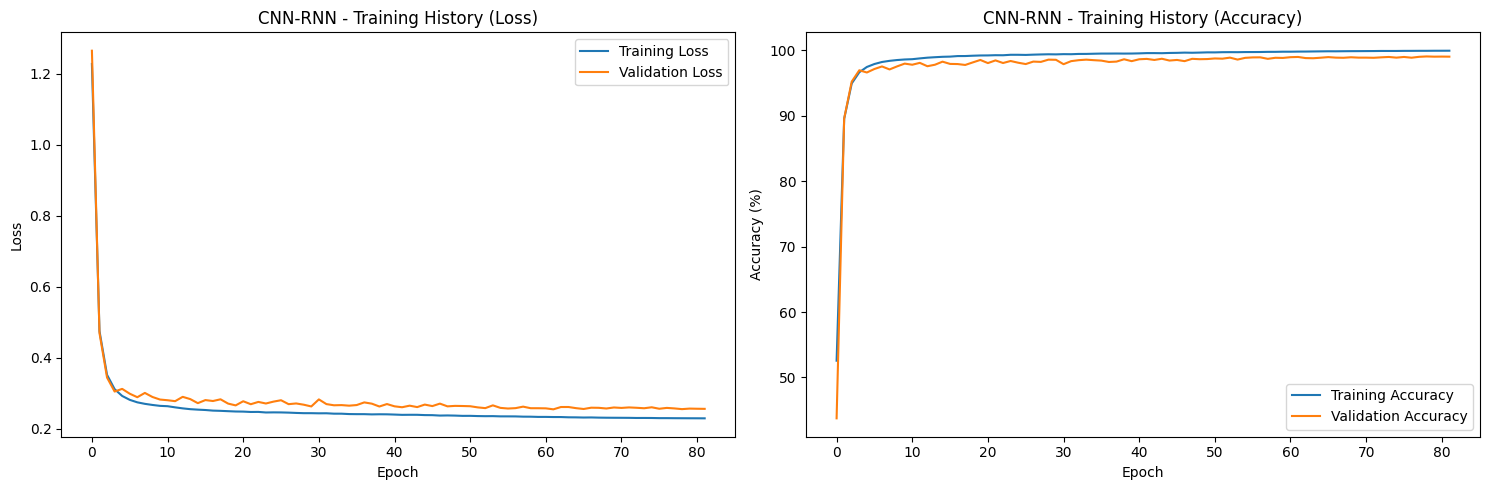

Testing: 100%|██████████| 685/685 [00:03<00:00, 218.70it/s]



Classification Report (CNN-RNN):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18118
           1       0.89      0.90      0.89       556
           2       0.97      0.97      0.97      1448
           3       0.80      0.88      0.84       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.95      0.94     21892
weighted avg       0.99      0.99      0.99     21892



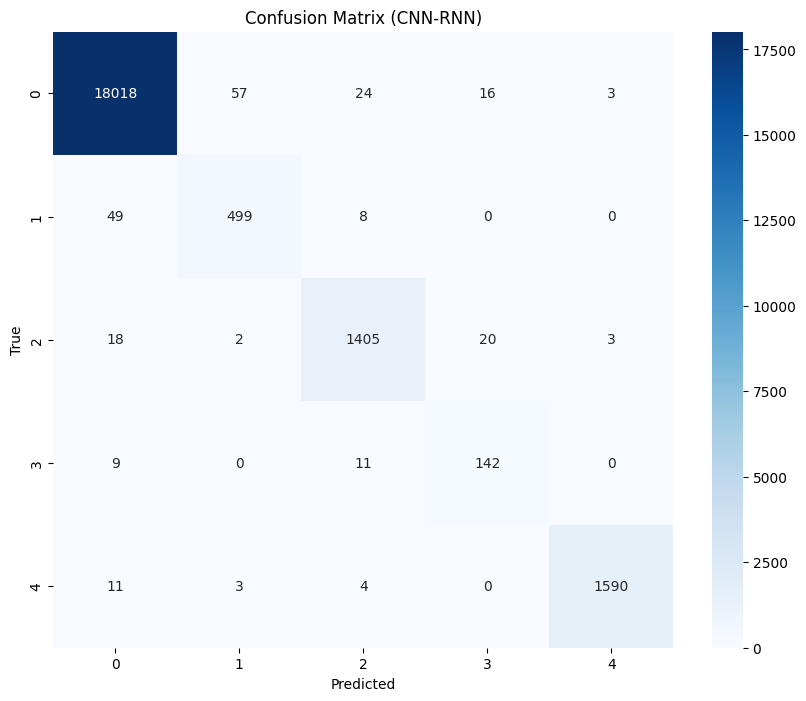

In [ ]:
model_name = 'CNN-RNN'

hybrid_model = ECG_CNN_RNN(**config[model_name]['model_params'])
# Train models
hybrid_trainer = train_model(hybrid_model, train_loader, val_loader, test_loader)

In [ ]:
# Get accuracies
accuracy = get_test_accuracy(hybrid_trainer.model, test_loader, model_name)

print("\nSummary:")
print(f"{hybrid_model.model_name} Test Accuracy: {accuracy:.2f}%")


Evaluating CNN-RNN model...
CNN-RNN Test Accuracy: 98.91%

Summary:
CNN-RNN Test Accuracy: 98.91%


Using device: cuda

Starting training for GRU...


Training: 100%|██████████| 10192/10192 [00:52<00:00, 192.43it/s]



Epoch [1/100]
Train Loss: 1.4606, Train Acc: 36.56%
Val Loss: 1.3474, Val Acc: 45.95%
Learning Rate: 0.000105


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.92it/s]



Epoch [2/100]
Train Loss: 0.5348, Train Acc: 87.55%
Val Loss: 0.4899, Val Acc: 89.58%
Learning Rate: 0.000204


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.81it/s]



Epoch [3/100]
Train Loss: 0.3637, Train Acc: 95.12%
Val Loss: 0.3429, Val Acc: 96.13%
Learning Rate: 0.000304


Training: 100%|██████████| 10192/10192 [00:52<00:00, 194.35it/s]



Epoch [4/100]
Train Loss: 0.3120, Train Acc: 97.26%
Val Loss: 0.3134, Val Acc: 96.75%
Learning Rate: 0.000403


Training: 100%|██████████| 10192/10192 [00:52<00:00, 194.87it/s]



Epoch [5/100]
Train Loss: 0.2889, Train Acc: 98.14%
Val Loss: 0.3181, Val Acc: 96.46%
Learning Rate: 0.000503


Training: 100%|██████████| 10192/10192 [00:51<00:00, 196.00it/s]



Epoch [6/100]
Train Loss: 0.2776, Train Acc: 98.53%
Val Loss: 0.2881, Val Acc: 97.75%
Learning Rate: 0.000602


Training: 100%|██████████| 10192/10192 [00:51<00:00, 196.53it/s]



Epoch [7/100]
Train Loss: 0.2710, Train Acc: 98.76%
Val Loss: 0.2903, Val Acc: 97.72%
Learning Rate: 0.000701


Training: 100%|██████████| 10192/10192 [00:52<00:00, 194.94it/s]



Epoch [8/100]
Train Loss: 0.2662, Train Acc: 98.88%
Val Loss: 0.2870, Val Acc: 97.93%
Learning Rate: 0.000801


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.83it/s]



Epoch [9/100]
Train Loss: 0.2635, Train Acc: 98.94%
Val Loss: 0.2830, Val Acc: 97.85%
Learning Rate: 0.000901


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.03it/s]



Epoch [10/100]
Train Loss: 0.2617, Train Acc: 98.99%
Val Loss: 0.2869, Val Acc: 97.84%
Learning Rate: 0.001000


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.52it/s]



Epoch [11/100]
Train Loss: 0.2604, Train Acc: 99.00%
Val Loss: 0.2832, Val Acc: 97.98%
Learning Rate: 0.001000


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.95it/s]



Epoch [12/100]
Train Loss: 0.2573, Train Acc: 99.09%
Val Loss: 0.2844, Val Acc: 97.90%
Learning Rate: 0.000999


Training: 100%|██████████| 10192/10192 [00:52<00:00, 194.50it/s]



Epoch [13/100]
Train Loss: 0.2558, Train Acc: 99.16%
Val Loss: 0.2885, Val Acc: 97.78%
Learning Rate: 0.000997


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.63it/s]



Epoch [14/100]
Train Loss: 0.2535, Train Acc: 99.19%
Val Loss: 0.2719, Val Acc: 98.36%
Learning Rate: 0.000995


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.33it/s]



Epoch [15/100]
Train Loss: 0.2529, Train Acc: 99.23%
Val Loss: 0.2720, Val Acc: 98.23%
Learning Rate: 0.000992


Training: 100%|██████████| 10192/10192 [00:51<00:00, 196.32it/s]



Epoch [16/100]
Train Loss: 0.2519, Train Acc: 99.25%
Val Loss: 0.2785, Val Acc: 98.15%
Learning Rate: 0.000989


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.51it/s]



Epoch [17/100]
Train Loss: 0.2514, Train Acc: 99.26%
Val Loss: 0.2642, Val Acc: 98.72%
Learning Rate: 0.000985


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.75it/s]



Epoch [18/100]
Train Loss: 0.2518, Train Acc: 99.26%
Val Loss: 0.2939, Val Acc: 97.46%
Learning Rate: 0.000981


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.46it/s]



Epoch [19/100]
Train Loss: 0.2506, Train Acc: 99.29%
Val Loss: 0.2752, Val Acc: 98.14%
Learning Rate: 0.000976


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.37it/s]



Epoch [20/100]
Train Loss: 0.2507, Train Acc: 99.29%
Val Loss: 0.2728, Val Acc: 98.33%
Learning Rate: 0.000970


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.50it/s]



Epoch [21/100]
Train Loss: 0.2502, Train Acc: 99.29%
Val Loss: 0.2672, Val Acc: 98.52%
Learning Rate: 0.000964


Training: 100%|██████████| 10192/10192 [00:51<00:00, 196.38it/s]



Epoch [22/100]
Train Loss: 0.2495, Train Acc: 99.32%
Val Loss: 0.2775, Val Acc: 97.97%
Learning Rate: 0.000957


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.39it/s]



Epoch [23/100]
Train Loss: 0.2509, Train Acc: 99.26%
Val Loss: 0.2760, Val Acc: 98.28%
Learning Rate: 0.000950


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.67it/s]



Epoch [24/100]
Train Loss: 0.2508, Train Acc: 99.26%
Val Loss: 0.2759, Val Acc: 98.06%
Learning Rate: 0.000942


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.04it/s]



Epoch [25/100]
Train Loss: 0.2500, Train Acc: 99.31%
Val Loss: 0.2715, Val Acc: 98.26%
Learning Rate: 0.000933


Training: 100%|██████████| 10192/10192 [00:51<00:00, 196.47it/s]



Epoch [26/100]
Train Loss: 0.2494, Train Acc: 99.32%
Val Loss: 0.2743, Val Acc: 98.34%
Learning Rate: 0.000924


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.46it/s]



Epoch [27/100]
Train Loss: 0.2520, Train Acc: 99.20%
Val Loss: 0.2820, Val Acc: 97.88%
Learning Rate: 0.000915


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.35it/s]



Epoch [28/100]
Train Loss: 0.2509, Train Acc: 99.25%
Val Loss: 0.2766, Val Acc: 98.01%
Learning Rate: 0.000905


Training: 100%|██████████| 10192/10192 [00:52<00:00, 195.52it/s]



Epoch [29/100]
Train Loss: 0.2502, Train Acc: 99.26%
Val Loss: 0.2751, Val Acc: 98.10%
Learning Rate: 0.000895


Training: 100%|██████████| 10192/10192 [00:54<00:00, 185.83it/s]



Epoch [30/100]
Train Loss: 0.2497, Train Acc: 99.27%
Val Loss: 0.2796, Val Acc: 98.04%
Learning Rate: 0.000884


Training: 100%|██████████| 10192/10192 [00:55<00:00, 184.50it/s]



Epoch [31/100]
Train Loss: 0.2490, Train Acc: 99.29%
Val Loss: 0.2724, Val Acc: 98.16%
Learning Rate: 0.000872


Training: 100%|██████████| 10192/10192 [00:52<00:00, 194.21it/s]



Epoch [32/100]
Train Loss: 0.2482, Train Acc: 99.34%
Val Loss: 0.2789, Val Acc: 98.04%
Learning Rate: 0.000860


Training: 100%|██████████| 10192/10192 [00:53<00:00, 189.86it/s]



Epoch [33/100]
Train Loss: 0.2486, Train Acc: 99.32%
Val Loss: 0.2892, Val Acc: 97.65%
Learning Rate: 0.000848


Training: 100%|██████████| 10192/10192 [00:53<00:00, 190.17it/s]



Epoch [34/100]
Train Loss: 0.2520, Train Acc: 99.17%
Val Loss: 0.2734, Val Acc: 98.18%
Learning Rate: 0.000835


Training: 100%|██████████| 10192/10192 [00:53<00:00, 190.75it/s]



Epoch [35/100]
Train Loss: 0.2517, Train Acc: 99.18%
Val Loss: 0.2786, Val Acc: 97.98%
Learning Rate: 0.000822


Training: 100%|██████████| 10192/10192 [00:53<00:00, 191.47it/s]



Epoch [36/100]
Train Loss: 0.2520, Train Acc: 99.19%
Val Loss: 0.2793, Val Acc: 98.02%
Learning Rate: 0.000809


Training: 100%|██████████| 10192/10192 [00:53<00:00, 190.72it/s]


Early stopping triggered at epoch 37
Restored best model from early stopper


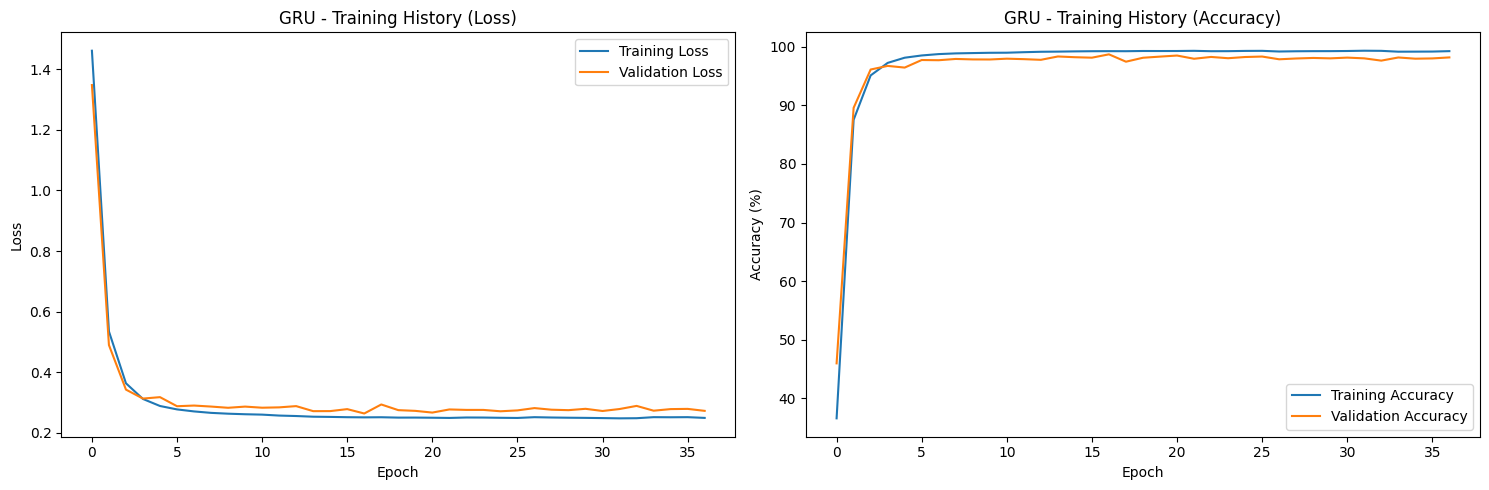

Testing: 100%|██████████| 685/685 [00:01<00:00, 552.59it/s]



Classification Report (GRU):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.84      0.86      0.85       556
           2       0.95      0.97      0.96      1448
           3       0.78      0.87      0.82       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.91      0.94      0.92     21892
weighted avg       0.99      0.99      0.99     21892



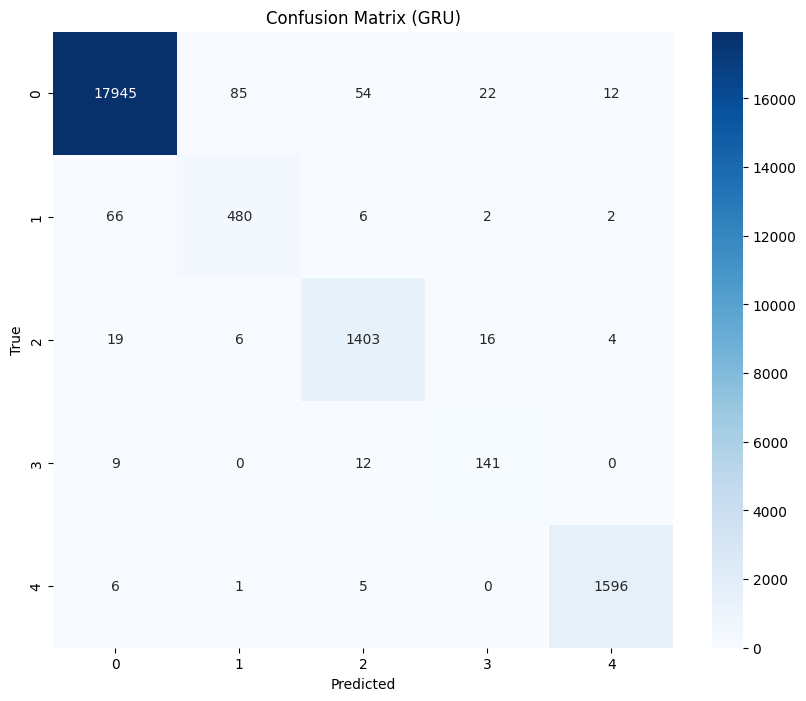

In [24]:
model_name = 'GRU'
gru_model = AttentionRNN(**config[model_name]['model_params'])

gru_trainer = train_model(gru_model, train_loader, val_loader, test_loader)

In [ ]:
# Get accuracies
accuracy = get_test_accuracy(gru_trainer.model, test_loader, model_name)

print("\nSummary:")
print(f"{gru_model.model_name} Test Accuracy: {accuracy:.2f}%")


Evaluating GRU model...


GRU Test Accuracy: 98.51%

Summary:
GRU Test Accuracy: 98.51%
